In [22]:
import numpy as np
import math
import psutil

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file


def generate_stock_data(key):
	vec = []
	vec_1 = []
	lines = open("data/" + key + ".csv", "r").read().splitlines()

	for line in lines[1:1000]:
		vec.append(float(line.split(",")[1]))

	return vec

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])


#30 year return rate
def risk_free_return_rate():
    return_rate = 2.56 / 100  # approximate annual U.S. Treasury bond return rate
    return (1 + return_rate)**(1 / 365) - 1

def calculate_sharpe(x):
    #x is the return on investment
    #for simplicity can also take log return
    mean = np.mean(x)
    std = np.std(x)
    sharpe = mean/std
    return sharpe




In [4]:
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def generate_replay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
				#print(type(target))

			target_f = self.model.predict(state)
			target_f[0][action] = target
			#print(type(target_f))
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay 

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from functions import *
import sys
import psutil
import time
from agent.agent import Agent
import csv
from csv import writer
import psutil
import humanize
import os
#import GPUtil as GPU
#GPUs = GPU.getGPUs()
#gpu = GPUs[0]

#sys.path.insert(0, '/Users/singularity/Super_Fast/q-trader/agent')
#from agent import agent
#Agent = agent.Agent()

if len(sys.argv) != 5:
	print ("Usage: python train.py [stock] [window] [episodes] [balance]")
	exit()


stock_name, window_size, episode_count,balance_int = sys.argv[1], int(sys.argv[2]), int(sys.argv[3]),int(sys.argv[4])
balance = balance_int
print("Portfolio Balance is currently {}".format(balance))
agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
buy_time = []
sell_time = []
trades = 0
cpu_percentages = []
trade_time_track = []

for ep in range(episode_count + 1):
	temper = ["The Usage of CPU when starting new episode is",psutil.cpu_percent()]
	with open('cpu_stats.csv','a',newline='') as fdq:
				csv_writer = writer(fdq)
				csv_writer.writerow(temper)

	print ("Episode " + str(ep) + "/" + str(episode_count))
	state = getState(0, window_size + 1,data)
	#get state is a numpy array (numpy ndarray)
	#print(type(state))

	total_profit = 0
	agent.inventory = []
	#print("For the episode {}, the cpu being used is {}".format(ep,psutil.cpu_percent()))
	cpu_percentages.append(psutil.cpu_percent())
	for t in range(l//32):
		if balance == 0:
			print("Trade when you have some money peasant")
			exit()

		action = agent.act(state)
		portfolio_value = len(agent.inventory) * data[t] + balance


		# sit
		next_state = getState(t + 1, window_size + 1,data)
		#print(next_state)
		reward = 0

		if action == 1:
			 # buy
			time_trade = time.time()
			agent.inventory.append(data[t])
			balance = balance - data[t]
			print("Trade executed at {}".format(time_trade))
			print ("Buy: " + formatPrice(data[t]))
			#buy_time.append(dates[t])
			trade_time_track.append(time_trade)
			trades+=1
			tpr = ['The Usage of CPU when executed buy is', psutil.cpu_percent()]
			with open('cpu_stats.csv','a',newline='') as fdq:
				csv_writer = writer(fdq)
				csv_writer.writerow(tpr)

		elif action == 2 and len(agent.inventory) > 0:
			time_trade = time.time()
			bought_price = agent.inventory.pop(0)
			diff = data[t] - bought_price
			reward = max(data[t] - bought_price, 0)
			balance = balance + data[t]
			print("Trade executed at {}".format(time_trade))
			total_profit += data[t] - bought_price
			temp_1 = [time_trade,diff]
			tpr = ['The Usage of CPU when executed sell is', psutil.cpu_percent()]
			with open('cpu_stats.csv','a',newline='') as fdq:
				csv_writer = writer(fdq)
				csv_writer.writerow(tpr) # sell


			print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
			trade_time_track.append(time_trade)
			with open('profitvstime.csv','a',newline='') as fdq:
				csv_writer = writer(fdq)
				csv_writer.writerow(temp_1)
			#sell_time.append(dates[t])
			trades+=1
		a,b = psutil.cpu_stats(),psutil.cpu_percent()
		#c = [gpu.memoryFree,gpu.memoryUsed,gpu.memoryUtil*100]
		temp = [a,b]	
		
		with open('cpu_usage.csv','a',newline='') as fd:
			csv_writer = writer(fd)
			csv_writer.writerow(temp)
			#fd.write(str(psutil.cpu_percent()))
		cpu_percentages.append(psutil.cpu_percent())	
		new_portfolio_value = len(agent.inventory)* data[t]  + balance
		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state
		return_rate = (new_portfolio_value - portfolio_value) / portfolio_value
		#with open('cpu_stats.csv','a') as fd:
		#	fd.write(psutil.cpu_stats())
		#print("CPU statistics are {}".format(psutil.cpu_stats()))
		#cpu_percentages.append(psutil.cpu_percent())
		#cpu_percentages.append(psutil.cpu_stats)
			#fd.write(str(psutil.cpu_percent()))

		#cpu_percentages.append(psutil.cpu_percent())

		#print("CPU consumption is {}".format(psutil.cpu_percent()))


		if done:
			print ("--------------------------------")
			print ("Total Profit: " + formatPrice(total_profit))
			print (" Current Portfolio Balance {}".format(balance))
			print("Number of trades made : {}".format(trades))
			print ("--------------------------------")
			print("CPU Stats {}".format(cpu_percentages))

		if len(agent.memory) > batch_size:
			tpr = ['The Usage of CPU when experiencing replayis', psutil.cpu_percent()]
			with open('cpu_stats.csv','a',newline='') as fdq:
				csv_writer = writer(fdq)
				csv_writer.writerow(tpr)
			agent.generate_replay(batch_size)

	if ep % 10 == 0:
		agent.model.save("models/model_ep" + str(ep))


KeyboardInterrupt: 

In [ ]:
#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from functions import *
import sys
from agent.agent import Agent
import psutil
#sys.path.insert(0, '/Users/singularity/Super_Fast/q-trader/agent')
#from agent import agent
#Agent = agent.Agent()

#if len(sys.argv) != 3:
#	print ("Usage: python evaluate.py [stock] [model]")
#	exit()

#stock_name, model_name = sys.argv[1], sys.argv[2]
stock_name,model_name = "hft_train","model_ep20"
model = load_model("models/" + model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = generate_stock_data(stock_name)
l = len(data) - 1
batch_size = 32

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []
buy_time = []
trade_time_buy = []
sell_time = []
trade_time_sell = []
min_trade_time = []

for t in range(l):
	action = agent.act(state)

	# sit
	next_state = getState(data, t + 1, window_size + 1)
	reward = 0

	if action == 1: # buy
		agent.inventory.append(data[t])
		print ("Buy: " + formatPrice(data[t]))
		#buy_time.append(dates[t])

	elif action == 2 and len(agent.inventory) > 0: # sell
		bought_price = agent.inventory.pop(0)
		reward = max(data[t] - bought_price, 0)
		total_profit += data[t] - bought_price
		print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
		#sell_time.append(dates[t])
	for i in range(len(buy_time) - 1):
		d1 = datetime.strptime(buy_time[i], "%Y-%m-%d")
		d2 = datetime.strptime(buy_time[i+1], "%Y-%m-%d")
		trade_time_buy.append(abs((d2-d1).days))
	for j in range(len(sell_time) - 1):
		d1 = datetime.strptime(sell_time[i], "%Y-%m-%d")
		d2 = datetime.strptime(sell_time[j], "%Y-%m-%d")
		trade_time_sell.append(abs((d1 - d2).days))
	#x_1 = min(trade_time_sell)
	#x_2 = min(trade_time_buy)


	done = True if t == l - 1 else False
	agent.memory.append((state, action, reward, next_state, done))
	state = next_state

	if done:
		print ("--------------------------------")
		print (stock_name + " Total Profit: " + formatPrice(total_profit))
		#print("Minimum Trading Time is {}".format(x_1,x_2))
		print ("--------------------------------")



Analysis

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
plt.rcParams["figure.figsize"] = [10.00, 6.50]
plt.rcParams["figure.autolayout"] = True

In [5]:
#columns = ["Time", "Profits_from_Selling"]
df = pd.read_csv("/Users/singularity/Super_Fast/q-trader/qtrader/q-trader/profitvstime.csv", header=None, usecols=[0,1],names=['Time','Profit_Selling'])

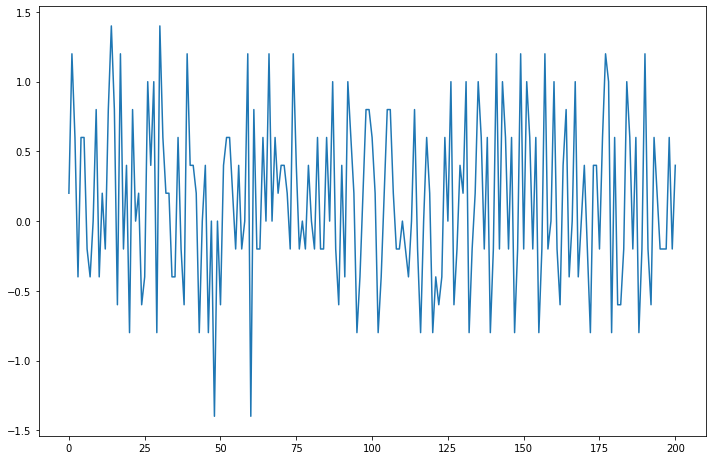

In [6]:
plt.plot(df['Profit_Selling'])

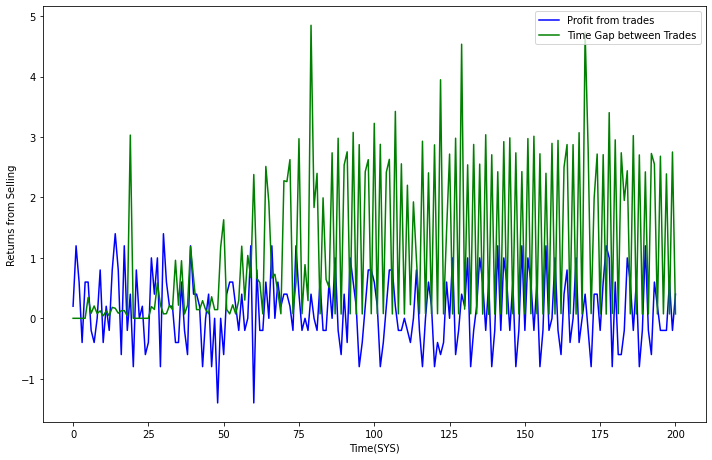

In [11]:
temp = []
for i in range(1,len(df)):
    #print(df['Time'][i] - df['Time'][i-1] )
    temp.append(df['Time'][i] - df['Time'][i-1])
    #df['latency'] = df['Time'][i] - df['Time'][i-1]
#print(df['latency'])
temp.insert(0,temp[0])
plt.plot(df.Profit_Selling,"-b",label="Profit from trades")
for i in range(len(temp)):
    temp[i] = temp[i] / 100

plt.plot(temp,"-g",label='Time Gap between Trades')
plt.legend(loc="upper right")
plt.xlabel('Time(SYS)')
plt.ylabel('Returns from Selling')
plt.show()

The above plot is the time taken between profitable trades (i.e. selling trades) and the profit return of those trades (positive or negative). This graph deals with the time specifically for sell trades and presents some important observations.

In the initial periods, where the trades profits less volatile though inconsistent in terms of spread, the time taken between these trades has relatively smaller periods. Some trades are executed in the order ranging from centi-seconds to milliseconds.

However as the agent progresses and stabilises its spread, the agent takes considerably longer periods to execute sell trades. This point can be argued on the basis of the data being used, however the agent is making both gains and losses in this period, which means that it has not yet achieved optimality of trading and is still training, which begets some more randomisation in terms of trading. 

Towards the later periods, where the spread stabilises and the profits get capped, the agent still takes substantial periods of time to execute selling trades, which are not consistent with high frequency standards. As the graph in the later section of this notebook shows, these are also periods of hefty computation utilisation.

In [13]:
df_3 = pd.read_csv("/Users/singularity/Super_Fast/q-trader/qtrader/q-trader/cpu_usage.csv",header=None,usecols = [0,1],names=['Stats','Usage'])

<class 'pandas.core.frame.DataFrame'>
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
3505    98.7
3506    98.6
3507    98.6
3508    98.6
3509    97.7
Name: Usage, Length: 3510, dtype: float64


Text(0.5, 1.0, 'CPU Usage')

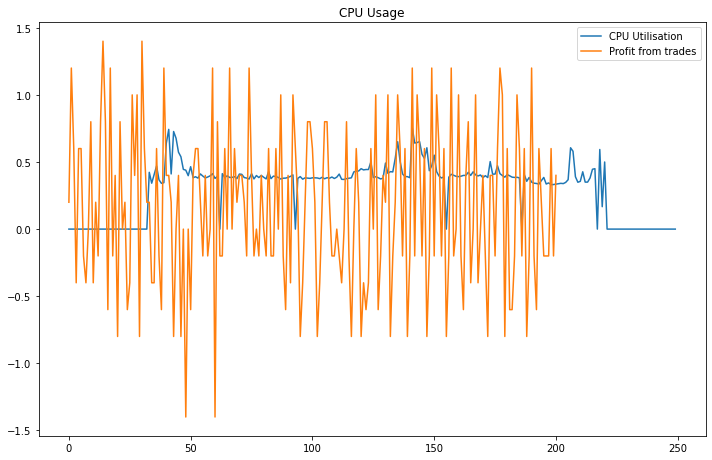

In [20]:
#print(df_3)
print(type(df_3))
list_2 = []
df_3[['Red','CTX']] = df_3['Stats'].str.split('(',expand=True)
#print(df_3['CTX']) 
for i in df_3['CTX']:
    #print(i)
    #print(i.split(',')[0][13:])
    list_2.append(int(i.split(',')[0][13:]))
x = df_3['Usage'].head(250)
print(df_3['Usage'])
plt.plot(x/100,label="CPU Utilisation")
plt.plot(df['Profit_Selling'],label="Profit from trades")
plt.legend(loc="upper right")
plt.title('CPU Usage')
#df_3[['CTSw','Interrupts','Other']] = df_3['CTX'].str.split(',',expand=True)
#print(df_3)

#print(type(df_2['Stats'].to_frame()))
#x = df_2['Stats'].to_frame()


#for i in range(10):
#    print(i)
#    df_2[['Stats','CTX']] = df_2['Stats'][i].split('(')[1].split(',')[0][13:]
    #print(df_2['Stats'][i])
#df_2['Stats'].str[23:28].astype(int)
#print(df_2['Stats'])

#print(df_2)
#print(23 to 28)

In [8]:
plt.plot((df_3['Usage'][0:201])/100,color='r')
plt.plot(df.Profit_Selling,color='g')

NameError: name 'df_3' is not defined

The above plot is between the profits made from selling the stocks as the agent learns to navigate in the environment and the computational power (CPU percentage) being utilised. In order to scale the quantities, CPU percentages are divided by 100.

The graph is critical in understanding the relation between the peak computational resource usage and how it is impacting the performance of the agent. 

The initial 0 usage seen in the graph is the first episode of training, where the agent makes a set of random decisions and stores the outcomes. Owing to the rather pre-programmed nature of this decision, the computational resources required in this particular step are minimal. However, once the consecutive episode of training initiates, which is where the Q model is actually using some of the previous results in order to make a future decision, computational requirements start to accelerate and also touch the peak. This is also the period where the training is at its lowest pace.

It is also worthy to note that the agent achieves its higest and lowest trading profits in this period, which indicates a load requirement being proposed by the model. Maintaining a period of relatively similar computational allocations and the agent also stabilises a region of its profit (x - [65,90] approximately).

The subsequent training periods also strike up the computational requirements however we notice that the agent becomes stable in terms of its earning, with its spikes being bounded and the spread of those bounds also being noticeable less volatile.

This exercise was a training of 100 episodes, and it one observes carefully towards the ending periods, the allocation of the computational resources show a downward trend.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/singularity/Super_Fast/q-trader/qtrader/q-trader/profitvstime.csv", header=None, usecols=[0,1],names=['Time','Profit_Selling'])

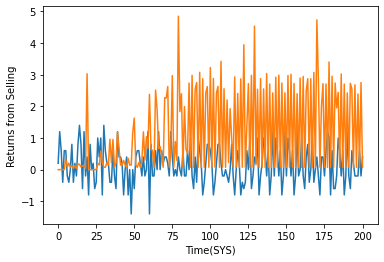

In [4]:
temp = []
for i in range(1,len(df)):
    #print(df['Time'][i] - df['Time'][i-1] )
    temp.append(df['Time'][i] - df['Time'][i-1])
    #df['latency'] = df['Time'][i] - df['Time'][i-1]
#print(df['latency'])
temp.insert(0,temp[0])
plt.plot(df.Profit_Selling)
for i in range(len(temp)):
    temp[i] = temp[i] / 100

plt.plot(temp)
plt.xlabel('Time(SYS)')
plt.ylabel('Returns from Selling')
plt.show()